This is a dataset annotator using SAM. For every image in the datset, it allows the user to mannually draw bounding boxes on images, generate masks, ans convert them into YOLO format for training purposes.

In [1]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import torch
import random
from matplotlib import pyplot as plt
import os

In [2]:
dataset_name = 'my_custom_dataset'
images_folder_path = "test_images"


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!

Segmenting the objects, this might take a while


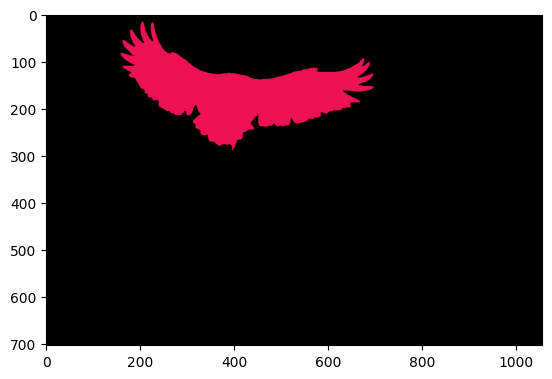

163 55
167 69
184 87
178 88
165 83
159 85
169 97
188 108
163 112
181 124
176 130
191 138
201 156
209 160
210 167
216 169
217 175
224 176
228 183
237 182
242 197
276 214
287 214
297 205
300 214
304 215
319 193
329 212
313 226
313 230
318 233
318 241
329 248
331 256
343 255
348 270
356 270
368 280
376 276
392 276
397 289
406 268
416 265
418 253
430 245
442 243
435 231
451 210
455 238
479 237
484 232
491 238
515 236
519 232
521 220
530 231
542 231
559 222
582 218
585 208
598 211
603 206
626 204
631 199
647 197
646 191
650 187
667 187
664 182
631 163
633 161
672 164
688 161
698 155
664 150
683 142
696 130
695 126
675 134
662 134
675 125
689 104
686 102
677 110
672 110
676 94
657 109
630 121
580 123
575 121
578 116
568 114
529 122
482 137
451 139
402 126
361 128
343 125
315 113
280 85
270 81
259 83
251 77
239 58
228 18
223 23
227 58
216 46
206 16
201 24
201 37
208 62
194 51
182 33
179 34
179 44
190 68
184 68


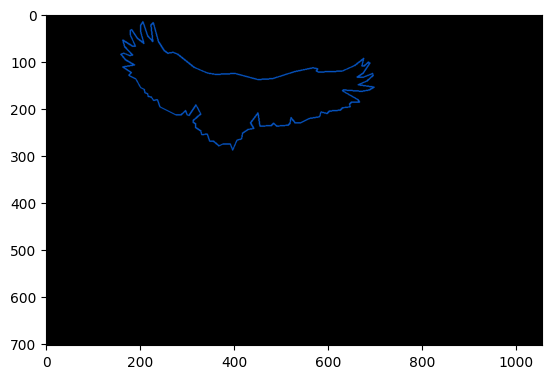

KeyboardInterrupt: Interrupted by user

In [3]:
image_files = [f for f in os.listdir(images_folder_path) if os.path.isfile(os.path.join(images_folder_path, f))]

for image_file in image_files:
    image_path = os.path.join(images_folder_path, image_file)
    img = cv2.imread(image_path)
    r = {}
    while(True):
        label = input("Enter the label for the mask (exit to move to net image): ")
        if label == 'exit':
            break
        if label not in r:
            r[label] = {"bounding_box": [], "masks": []}
        while True:
            bbox = cv2.selectROI("Interactive Menu", img)
        
            convert = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            r[label]["bounding_box"].append(np.asarray(convert))
            cv2.destroyAllWindows()

            cont = input("Draw another bounding box for the same label? (y/n): ")
            if cont.lower() != 'y':
                break  # Move to the next label


    print("\nSegmenting the objects, this might take a while")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
    # sam.to(device)
    mask_predictor = SamPredictor(sam)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_predictor.set_image(img2)

    for label in r:
        for bbox in r[label]["bounding_box"]:
            mask, _, _ = mask_predictor.predict(box=bbox, multimask_output=False)
            r[label]["masks"].append(mask[0])

    # mask_visualization = np.zeros_like(img)
    # for label in r:
    #     color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    #     for mask in r[label]["masks"]:
    #         mask_visualization[mask] = color

    # plt.imshow(mask_visualization)
    # plt.show()

    color_mask = np.zeros_like(img)
    for label in r:
        for mask in r[label]["masks"]:
            mask[mask > 0] = 255
            mask = mask.astype(np.uint8)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            approx_contours = [cv2.approxPolyDP(contour, 0.001 * cv2.arcLength(contour, True), True) for contour in contours]
            color = [int(c) for c in np.random.choice(range(256), size=3)]  # Random color for each instance
            for i, contour in enumerate(approx_contours):
                cv2.drawContours(color_mask, [contour], -1, color, 2)  # Fill the contour with the color
                for point in contour:
                    print(point[0][0], point[0][1])

    plt.imshow(color_mask)
    plt.show()



In [ ]:
contours

(array([[[411,  81]],
 
        [[410,  82]],
 
        [[408,  82]],
 
        ...,
 
        [[436,  82]],
 
        [[430,  82]],
 
        [[429,  81]]], dtype=int32),)

In [ ]:
contours[0].shape

(951, 1, 2)

In [ ]:
approx_contours[0].shape

(67, 1, 2)